Dataset from: https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews

In [4]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("marlesson/myanimelist-dataset-animes-profiles-reviews")

print("Path to dataset files:", path)

100%|██████████| 217M/217M [00:01<00:00, 115MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews/versions/1


In [5]:
dataset_df = pd.read_csv(os.path.join(path, "reviews.csv"))

In [6]:
dataset_df.head()

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


In [7]:
dataset_df.shape

(192112, 7)

In [ ]:
# remove unused featuress
dataset_df.drop(columns=['uid', 'scores', 'link'], inplace=True)

#drop null values
dataset_df.dropna(subset=['profile', 'anime_uid', 'text', 'score'], inplace=True)

In [ ]:
import re

# Function to clean review text
def clean_review(text):
    # Remove the beginning pattern
    text = re.sub(r'^\s*more pics.*?Enjoyment\s*\d+\s*', '', text, flags=re.DOTALL)
    # Remove the trailing pattern
    text = re.sub(r'\n\n\s*Helpful\s*$', '', text, flags=re.DOTALL)
    return text.strip()

# Apply to the review column
dataset_df['text'] = dataset_df['text'].apply(clean_review)

In [ ]:
from datetime import datetime
import pandas as pd

# Load the dataset
profiles = pd.read_csv(os.path.join(path, "profiles.csv"))
print(len(profiles))
profiles.drop('link', axis=1, inplace=True)

# Ensure that 'birthday' and 'gender' are not missing (optional)
profiles = profiles.dropna(subset=['birthday', 'gender'])

# Use pandas' factorize to convert 'username' into numerical IDs
profiles['user_id'] = pd.factorize(profiles['profile'])[0]
profiles.drop(columns=['profile'], inplace=True)

# Convert to list of dictionaries for further processing
profiles = profiles.to_dict(orient='records')

# Parse birthday and calculate age
current_date = datetime.now()

for profile in profiles:
    try:
        # Convert birthday to datetime and calculate age
        birthday = datetime.strptime(profile['birthday'], '%b %d, %Y')
        profile['age'] = current_date.year - birthday.year - \
                         ((current_date.month, current_date.day) < (birthday.month, birthday.day))
    except (ValueError, KeyError, TypeError):
        # Handle missing or malformed birthday values
        profile['age'] = None

81727


In [ ]:
profiles[0]

{'gender': 'Male',
 'birthday': 'Oct 2, 1994',
 'favorites_anime': "['33352', '25013', '5530', '33674', '1482', '269', '18245', '2904', '27899', '17074', '12291', '226', '28851', '8525', '6594', '4981', '1698', '457', '235', '34618']",
 'user_id': 0,
 'age': 30}

In [ ]:
len(profiles)

43636

In [ ]:
# Use pandas' factorize to convert 'username' into numerical IDs
dataset_df['user_id'] = pd.factorize(dataset_df['profile'])[0]
dataset_df.drop(columns=['profile'], inplace=True)

In [ ]:
# Convert dataframe into a list of dictionaries for indexing
dataset = dataset_df.to_dict(orient='records')

In [ ]:
dataset[0]

{'anime_uid': 34096,
 'text': 'First things first. My "reviews" system is explained on a blog entry. Which can be found through my profile. \r\n------ \r\n \r\nI\'m going to keep this "review" more of a opinion of Gintama\'s overall and then this season specific. \r\n \r\nAnyhow. What I have always loved regarding Gintama, is its content of everything. I love the comedy, its absurd, random, can be vile, dirty, sweet, anyhow, everything. Have laughed countless times in this franchise. Also the humor they have also is heavily reference based, a.k.a parodies of different anime, shows, manga, live stuff, real world, anime production and so on. Anyhow, comedy/parody side of this franchise i absolutely love. \r\n \r\nNow, 2nd side of this show is the serious dramas, epic battle shounens and so on.. There are arcs that are fully comedy, arcs that are fully serious and mixtures of both. Serious side is usually quite dramatic and managed to somewhat tear me up now and then. Whilst the action se

In [ ]:
# add features from profiles to dataset
# Step 1: Create a mapping from profile to gender and age
profile_mapping = {p['user_id']: {'gender': p['gender'], 'age': p['age']} for p in profiles}

# Step 2: Update dataset entries with gender and age from profiles
for entry in dataset:
    profile_name = entry['user_id']
    if profile_name in profile_mapping:
        entry.update(profile_mapping[profile_name])

In [ ]:
animes = pd.read_csv(os.path.join(path, "animes.csv"))

In [ ]:
animes.shape

(19311, 12)

In [ ]:
# some item features could be useful: title (length?), genres, date of first aired, episodes, members, popularity, ranked, score
animes.head()
animes.drop(columns=['synopsis', 'img_url', 'link'])

,uid,title,genre,aired,episodes,members,popularity,ranked,score
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82
1,23273,Shigatsu wa Kimi no Uso,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83
2,34599,Made in Abyss,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83
3,5114,Fullmetal Alchemist: Brotherhood,"['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23
4,31758,Kizumonogatari III: Reiketsu-hen,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83
...,...,...,...,...,...,...,...,...,...
19306,32979,Flip Flappers,"['Sci-Fi', 'Adventure', 'Comedy', 'Magic']","Oct 6, 2016 to Dec 29, 2016",13.0,134252,843,1070.0,7.73
19307,123,Fushigi Yuugi,"['Adventure', 'Fantasy', 'Magic', 'Martial Art...","Apr 6, 1995 to Mar 28, 1996",52.0,84407,1292,1071.0,7.73
19308,1281,Gakkou no Kaidan,"['Mystery', 'Horror', 'Supernatural']","Oct 22, 2000 to Mar 25, 2001",19.0,83093,1314,1073.0,7.73
19309,450,InuYasha Movie 2: Kagami no Naka no Mugenjo,"['Action', 'Adventure', 'Comedy', 'Historical'...","Dec 21, 2002",1.0,71989,1469,1077.0,7.73


In [ ]:
# calculate anime age
animes_dictionary = animes.to_dict(orient='records')

for anime in animes_dictionary:
    try:
        # Convert air_start to datetime and calculate age
        air_start = datetime.strptime(anime['aired'].split("to")[0].strip(), '%b %d, %Y')
        anime['anime_age'] = current_date.year - air_start.year - \
                         ((current_date.month, current_date.day) < (air_start.month, air_start.day))
    except (ValueError, KeyError, TypeError):
        # Handle missing or malformed birthday values
        anime['anime_age'] = None

animes = pd.DataFrame.from_dict(animes_dictionary)

In [ ]:
animes_dictionary[0]

{'uid': 28891,
 'title': 'Haikyuu!! Second Season',
 'synopsis': "Following their participation at the Inter-High, the Karasuno High School volleyball team attempts to refocus their efforts, aiming to conquer the Spring tournament instead.  \r\n \r\nWhen they receive an invitation from long-standing rival Nekoma High, Karasuno agrees to take part in a large training camp alongside many notable volleyball teams in Tokyo and even some national level players. By playing with some of the toughest teams in Japan, they hope not only to sharpen their skills, but also come up with new attacks that would strengthen them. Moreover, Hinata and Kageyama attempt to devise a more powerful weapon, one that could possibly break the sturdiest of blocks.  \r\n \r\nFacing what may be their last chance at victory before the senior players graduate, the members of Karasuno's volleyball team must learn to settle their differences and train harder than ever if they hope to overcome formidable opponents old a

In [ ]:
animes['title_length'] = [len(d) for d in animes['title']]
animes_dictionary = animes.to_dict(orient='records')

In [ ]:
# add features from anime to dataset
# Step 1: Create a mapping from uid to anime_age
anime_mapping = {a['uid']: {'anime_age': a['anime_age'], 'title_length': a['title_length'], 'members': a['members'], 'popularity':a['popularity']} for a in animes_dictionary}

# Step 2: Update dataset entries with anime_age and title_length from animes
for entry in dataset:
    anime_uid = entry['anime_uid']
    if anime_uid in anime_mapping:
        entry.update(anime_mapping[anime_uid])

In [ ]:
dataset[0]

{'anime_uid': 34096,
 'text': 'First things first. My "reviews" system is explained on a blog entry. Which can be found through my profile. \r\n------ \r\n \r\nI\'m going to keep this "review" more of a opinion of Gintama\'s overall and then this season specific. \r\n \r\nAnyhow. What I have always loved regarding Gintama, is its content of everything. I love the comedy, its absurd, random, can be vile, dirty, sweet, anyhow, everything. Have laughed countless times in this franchise. Also the humor they have also is heavily reference based, a.k.a parodies of different anime, shows, manga, live stuff, real world, anime production and so on. Anyhow, comedy/parody side of this franchise i absolutely love. \r\n \r\nNow, 2nd side of this show is the serious dramas, epic battle shounens and so on.. There are arcs that are fully comedy, arcs that are fully serious and mixtures of both. Serious side is usually quite dramatic and managed to somewhat tear me up now and then. Whilst the action se

## Exploratory Data Analysis

## User Features

In [ ]:
profiles_df = pd.DataFrame.from_dict(profiles)

# # dropping profile names bc some explicit
# profiles_df = profiles_df.drop(columns=['profile'])
profiles_df.head()

,gender,birthday,favorites_anime,user_id,age
0,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '2...",0,30.0
1,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '925...",1,24.0
2,Male,Sep 5,"['5680', '849', '2904', '3588', '37349']",2,NaN
3,Male,"Oct 30, 1999","['4181', '7791', '9617', '5680', '2167', '4382...",3,25.0
4,Male,"Jan 1, 1985","['11061', '30', '6594', '28701', '10087', '674...",4,39.0


In [ ]:
combined_df = pd.DataFrame.from_dict(dataset)
combined_df = combined_df.dropna(subset=['gender'])

### Age

In [ ]:
profiles_df['age'].describe()

,age
count,34504.000000
mean,30.038459
std,7.785084
min,3.000000
25%,26.000000
50%,29.000000
75%,33.000000
max,94.000000


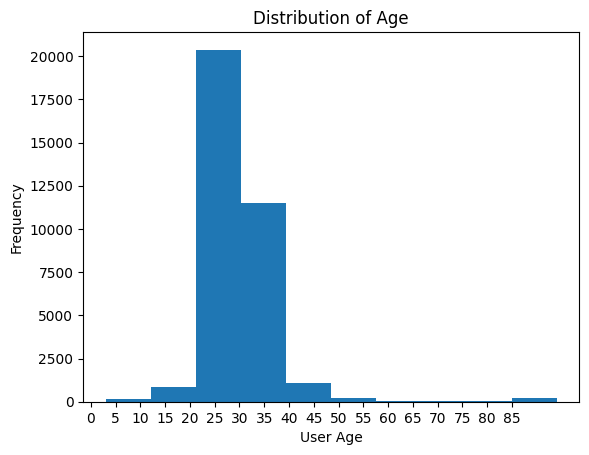

In [ ]:
# age of user
plt.hist(profiles_df['age'])
plt.xticks(ticks=np.arange(0, 90, 5))
plt.title('Distribution of Age')
plt.xlabel('User Age')
plt.ylabel('Frequency')
plt.show()

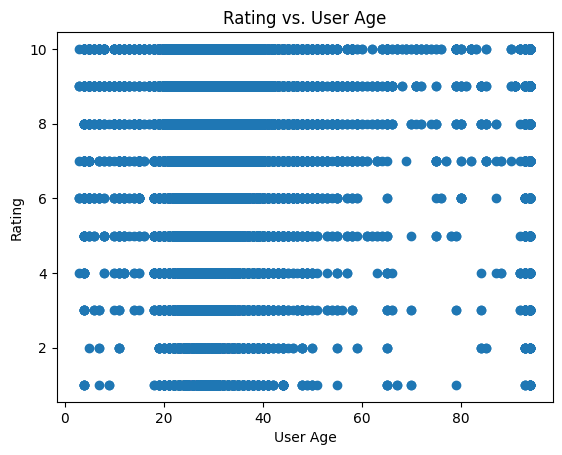

In [ ]:
ratings = combined_df['score']
ages = combined_df['age']

plt.scatter(ages, ratings)
plt.xlabel("User Age")
plt.ylabel("Rating")
plt.title("Rating vs. User Age")
plt.show()

### Gender

In [ ]:
profiles_df['gender'].value_counts()

,count
gender,
Male,29942
Female,13082
Non-Binary,612


In [ ]:
genderAverages = defaultdict(list)
dataset_df_cleaned = combined_df.to_dict(orient='records')

for d in dataset_df_cleaned:
  # print(d['gender'])
  genderAverages[d['gender']].append(d['score'])

for k in genderAverages:
    genderAverages[k] = sum(genderAverages[k]) / len(genderAverages[k])

In [ ]:
genderAverages

defaultdict(list,
            {'Male': 7.728434504792332,
             'Female': 7.674952073893342,
             'Non-Binary': 7.52766308835673})

In [ ]:
xplot = list(genderAverages.keys())
xplot.sort()
yplot = [genderAverages[k] for k in xplot]

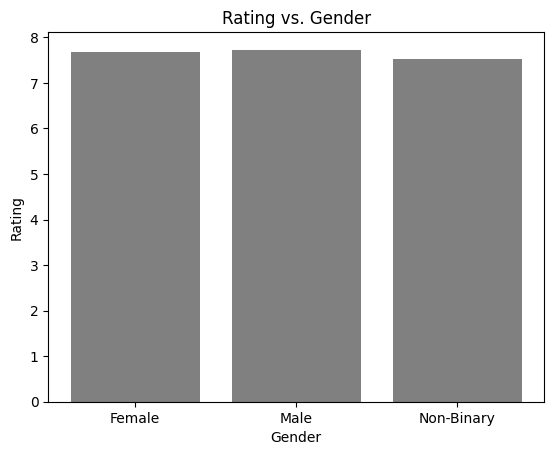

In [ ]:
plt.bar(xplot,yplot,color='grey',lw=0)
plt.ylabel("Rating")
plt.xlabel("Gender")
plt.title(r"Rating vs. Gender")
plt.show()

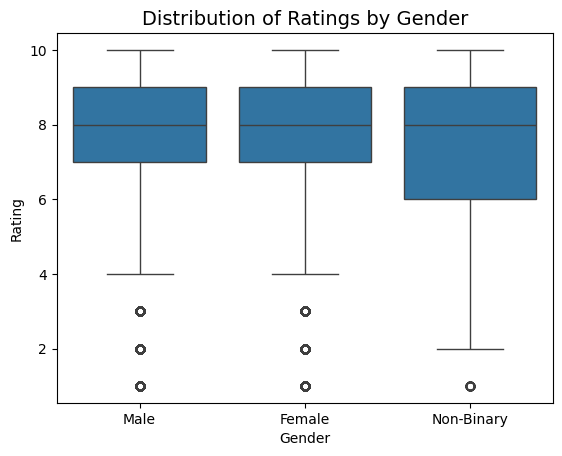

In [ ]:
sns.boxplot(data=combined_df, x='gender', y='score')
plt.title('Distribution of Ratings by Gender', fontsize=14)
plt.xlabel('Gender')
plt.ylabel('Rating')
plt.show()

## Item Features

In [ ]:
len(animes)

19311

### title Length

In [ ]:
combined_df['title_length'].describe()

,title_length
count,155059.000000
mean,20.358844
std,12.710869
min,1.000000
25%,11.000000
50%,17.000000
75%,26.000000
max,98.000000


In [ ]:
title_lengths = combined_df['title_length']
ratings = combined_df['score']

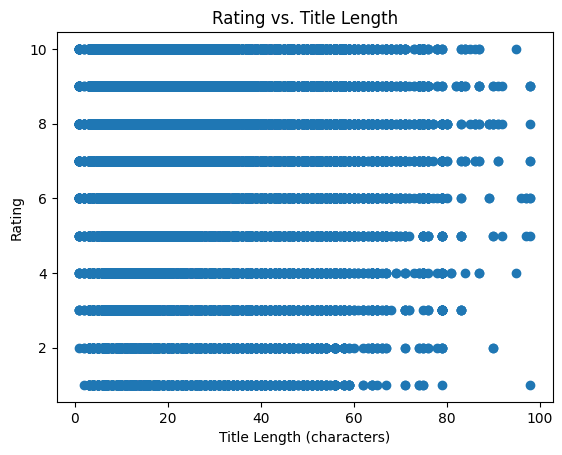

In [ ]:
plt.scatter(title_lengths, ratings)
plt.xlabel("Title Length (characters)")
plt.ylabel("Rating")
plt.title("Rating vs. Title Length")
plt.show()

### review length

In [ ]:
combined_df['text_length'] = [len(d) for d in combined_df['text']]

In [ ]:
combined_df['text_length'].describe()

,text_length
count,155059.000000
mean,2992.948800
std,2924.165256
min,80.000000
25%,1134.000000
50%,2140.000000
75%,3831.000000
max,63663.000000


In [ ]:
review_lengths = combined_df['text_length']
ratings = combined_df['score']

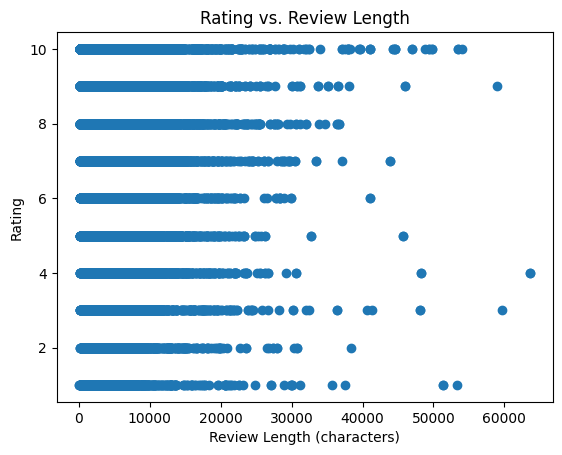

In [ ]:
plt.scatter(review_lengths, ratings)
plt.xlabel("Review Length (characters)")
plt.ylabel("Rating")
plt.title("Rating vs. Review Length")
plt.show()

### genre (optional)

### age of anime

In [ ]:
combined_df['anime_age'].describe()

,anime_age
count,154554.000000
mean,14.073534
std,7.296961
min,4.000000
25%,9.000000
50%,13.000000
75%,18.000000
max,107.000000


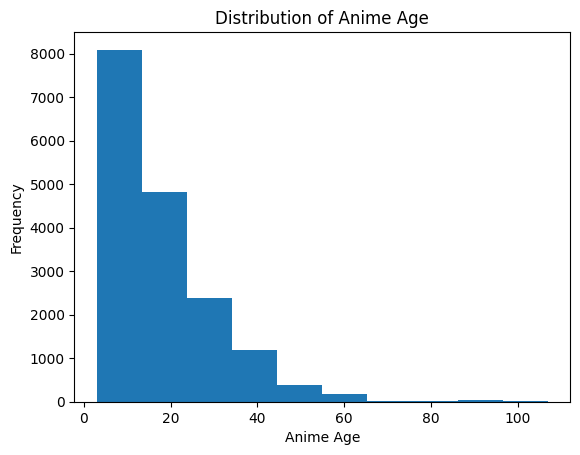

In [ ]:
# age of user
plt.hist(animes['anime_age'])
plt.title('Distribution of Anime Age')
plt.xlabel('Anime Age')
plt.ylabel('Frequency')
plt.show()

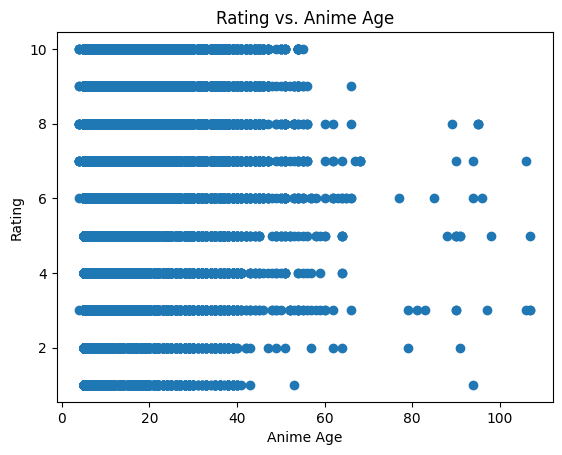

In [ ]:
ratings = combined_df['score']
anime_ages = combined_df['anime_age']

plt.scatter(anime_ages, ratings)
plt.xlabel("Anime Age")
plt.ylabel("Rating")
plt.title("Rating vs. Anime Age")
plt.show()

### members

In [ ]:
combined_df['members'].describe()

,members
count,1.550590e+05
mean,4.424102e+05
std,4.059208e+05
min,5.700000e+01
25%,1.225630e+05
50%,3.380330e+05
75%,6.563410e+05
max,1.871043e+06


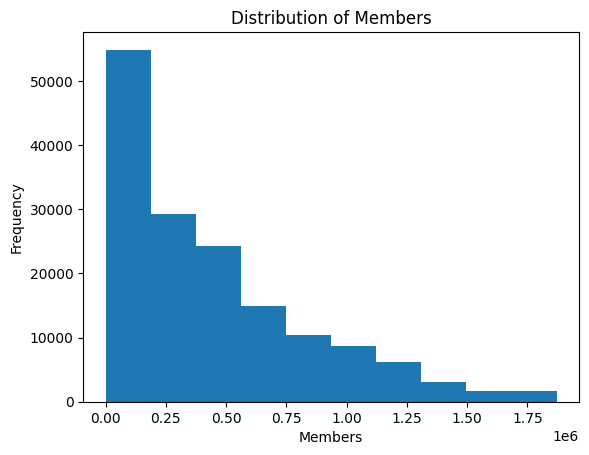

In [ ]:
plt.hist(combined_df['members'])
plt.title('Distribution of Members')
plt.xlabel('Members')
plt.ylabel('Frequency')
plt.show()

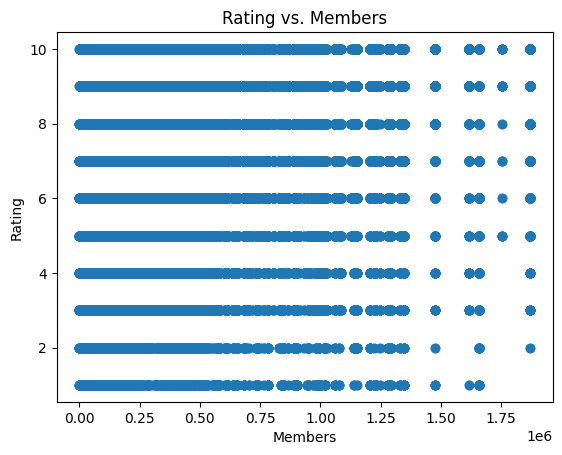

In [ ]:
ratings = combined_df['score']
anime_ages = combined_df['members']

plt.scatter(anime_ages, ratings)
plt.xlabel("Members")
plt.ylabel("Rating")
plt.title("Rating vs. Members")
plt.show()

### popularity

In [ ]:
combined_df['popularity'].describe()

,popularity
count,155059.000000
mean,857.405865
std,1506.914256
min,1.000000
25%,78.000000
50%,287.000000
75%,919.000000
max,16084.000000


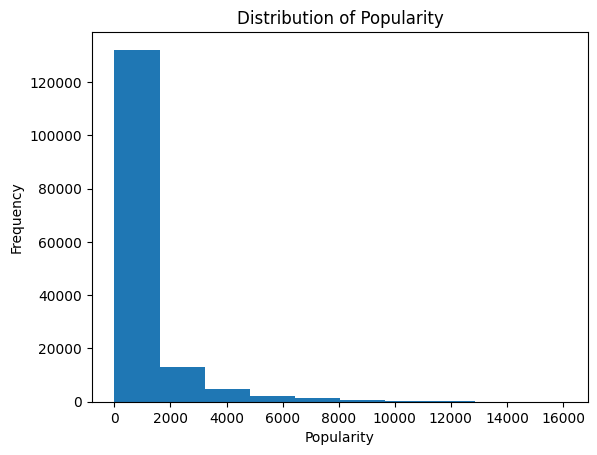

In [ ]:
plt.hist(combined_df['popularity'])
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

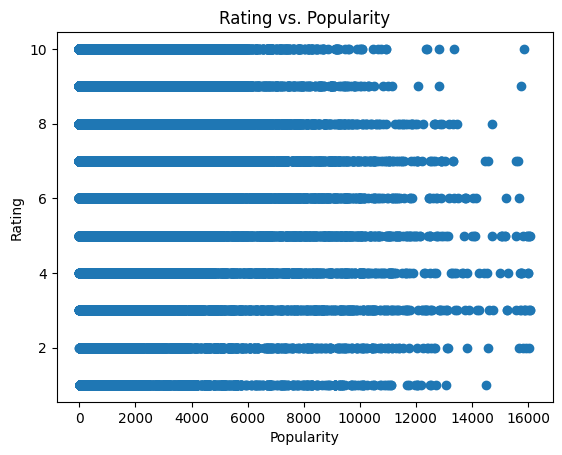

In [ ]:
ratings = combined_df['score']
popularities = combined_df['popularity']

plt.scatter(popularities, ratings)
plt.xlabel("Popularity")
plt.ylabel("Rating")
plt.title("Rating vs. Popularity")
plt.show()

# Imputing Missing Values/Data Structures for Model Building

In [ ]:
# Calculate the mean age (excluding None or missing)
valid_ages = [d['age'] for d in dataset if d.get('age') is not None]
mean_age = np.mean(valid_ages)

# Impute missing ages with the mean
for d in dataset:
    if 'age' not in d or d['age'] is None:
        d['age'] = mean_age

In [ ]:
from collections import Counter

# Get the most frequent gender
genders = [d['gender'] for d in dataset if d.get('gender') is  not None]
most_common_gender = Counter(genders).most_common(1)[0][0]

# Impute missing genders with the most common gender
for d in dataset:
    if 'gender' not in d or d['gender'] is None:
        d['gender'] = most_common_gender

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train+validation and test sets
train_valid, ratingsTest = train_test_split(dataset, test_size=0.2, random_state=42)

# Split train+validation into train and validation sets
ratingsTrain, ratingsValid = train_test_split(train_valid, test_size=0.2, random_state=42)

# 64% train/16% valid/20% test split

ratingsPerUser = defaultdict(list)
ratingsPerAnime = defaultdict(list)
animesPerUser = defaultdict(set)
usersPerAnime = defaultdict(set)
ratingDict = defaultdict(int)

for d in ratingsTrain:
    anime, user, rating = d['anime_uid'], d['user_id'], d['score']
    ratingsPerUser[user].append((anime,rating))
    ratingsPerAnime[anime].append((user,rating))
    animesPerUser[user].add(anime)
    usersPerAnime[anime].add(user)
    ratingDict[(user,anime)] = rating

# Baseline 1: Global Averages #

In [ ]:
trainRatings = [d['score'] for d in ratingsTrain]
globalAverage = sum(trainRatings) * 1.0 / len(trainRatings)
print(globalAverage)


7.565696903644541


In [ ]:
validMSE = 0
for d in ratingsValid:
  se = (d['score'] - globalAverage)**2
  validMSE += se

validMSE /= len(ratingsValid)

print("Validation MSE (average only) = " + str(validMSE))

Validation MSE (average only) = 5.1100341882489735


In [ ]:
testMSE = 0
for d in ratingsTest:
  se = (d['score'] - globalAverage)**2
  testMSE += se

testMSE /= len(ratingsTest)

print("Test MSE (average only) = " + str(testMSE))

Test MSE (average only) = 5.067718829474009


osheen


In [ ]:
userAverage = {}
for u in ratingsPerUser:
    ratings = [d[1] for d in ratingsPerUser[u]]
    userAverage[u] = sum(ratings) * 1.0 / len(ratings)

In [ ]:
validMSE = 0
print(ratingsValid)


validMSE /= len(ratingsValid)

print("Validation MSE (average only) = " + str(validMSE))

Buffered data was truncated after reaching the output size limit.

# Baseline 2: Simple (bias only) Latent Factor-Based Recommender #

In [ ]:
betaU = {}
betaI = {}
for u in ratingsPerUser:
    betaU[u] = 0

for i in ratingsPerAnime:
    betaI[i] = 0

In [ ]:
alpha = globalAverage

In [ ]:
def iterate(lamb):
    newAlpha = 0
    for d in ratingsTrain:
      anime = d['anime_uid']
      user = d['user_id']
      rating = d['score']
      newAlpha += rating - (betaU[user] + betaI[anime])
    alpha = newAlpha / len(ratingsTrain)
    for user in ratingsPerUser:
        newBetaU = 0
        for anime,rating in ratingsPerUser[user]:
            newBetaU += rating - (alpha + betaI[anime])
        betaU[user] = newBetaU / (lamb + len(ratingsPerUser[user]))
    for anime in ratingsPerAnime:
        newBetaI = 0
        for user,rating in ratingsPerAnime[anime]:
            newBetaI += rating - (alpha + betaU[user])
        betaI[anime] = newBetaI / (lamb + len(ratingsPerAnime[anime]))
    mse = 0
    for d in ratingsTrain:
      anime = d['anime_uid']
      user = d['user_id']
      rating = d['score']
      prediction = alpha + betaU[user] + betaI[anime]
      mse += (rating - prediction)**2
    regularizer = 0
    for user in betaU:
        regularizer += betaU[user]**2
    for anime in betaI:
        regularizer += betaI[anime]**2
    mse /= len(ratingsTrain)
    return mse, mse + lamb*regularizer

In [ ]:
mse,objective = iterate(1)
newMSE,newObjective = iterate(1)
iterations = 2

In [ ]:
while iterations < 10 or objective - newObjective > 0.0001:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(1)
    iterations += 1
    print("Objective after "
        + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after "
        + str(iterations) + " iterations = " + str(newMSE))

Objective after 3 iterations = 61157.87064793187
MSE after 3 iterations = 1.6765069361643967
Objective after 4 iterations = 60986.627662573126
MSE after 4 iterations = 1.6711822194458998
Objective after 5 iterations = 60899.97716742955
MSE after 5 iterations = 1.6692257300248448
Objective after 6 iterations = 60826.81888006839
MSE after 6 iterations = 1.668251953780407
Objective after 7 iterations = 60764.996463851676
MSE after 7 iterations = 1.6676515040403574
Objective after 8 iterations = 60714.58907843301
MSE after 8 iterations = 1.6672273472894525
Objective after 9 iterations = 60674.0251856582
MSE after 9 iterations = 1.6669023788083766
Objective after 10 iterations = 60641.269312599215
MSE after 10 iterations = 1.6666410914243555
Objective after 11 iterations = 60614.49776351079
MSE after 11 iterations = 1.6664245866659049
Objective after 12 iterations = 60592.276485630086
MSE after 12 iterations = 1.6662414870589726
Objective after 13 iterations = 60573.53817035047
MSE after 13

In [ ]:
validMSE = 0
for d in ratingsValid:
  anime = d['anime_uid']
  user = d['user_id']
  rating = d['score']
  bu = 0
  bi = 0
  if user in betaU:
    bu = betaU[user]
  if anime in betaI:
    bi = betaI[anime]
  prediction = alpha + bu + bi
  validMSE += (rating - prediction)**2

validMSE /= len(ratingsValid)
print("Validation MSE = " + str(validMSE))

Validation MSE = 3.148578314205397


In [ ]:
testMSE = 0
for d in ratingsTest:
  anime = d['anime_uid']
  user = d['user_id']
  rating = d['score']
  bu = 0
  bi = 0
  if user in betaU:
    bu = betaU[user]
  if anime in betaI:
    bi = betaI[anime]
  prediction = alpha + bu + bi
  testMSE += (rating - prediction)**2

testMSE /= len(ratingsTest)
print("Test MSE = " + str(testMSE))

Test MSE = 3.151332472501748


# Latent Factor Model (SVD)

In [ ]:
# Initialize U and V randomly

n_users = len(ratingsPerUser)
n_animes = len(ratingsPerAnime)
k = 10  # Number of latent factors

U = np.random.normal(scale=1./k, size=(n_users, k))
V = np.random.normal(scale=1./k, size=(n_animes, k))

In [ ]:
def train_latent_factor_model(U, V, ratingsTrain, ratingDict, learning_rate=0.01, reg=0.1, epochs=10):
    for epoch in range(epochs):
        total_loss = 0
        for (user, anime), rating in ratingDict.items():
            u_idx, i_idx = user, anime  # Ensure IDs map to indices
            pred = np.dot(U[u_idx], V[i_idx])
            error = rating - pred
            total_loss += error ** 2

            # Update rules
            U[u_idx] += learning_rate * (error * V[i_idx] - reg * U[u_idx])
            V[i_idx] += learning_rate * (error * U[u_idx] - reg * V[i_idx])

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")
    return U, V

In [ ]:
!pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl.metadata (327 bytes)
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357284 sha256=aab09c70b0e3ad8b0da19221e5bffa6d089834510488f85f30ea71d7b15b270a
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
# Latent factor model using SVD

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Convert ratingsTrain into Surprise format
reader = Reader(rating_scale=(1, 10))  # Adjust the scale based on your dataset
train_data = Dataset.load_from_df(
    pd.DataFrame([(d['user_id'], d['anime_uid'], d['score']) for d in ratingsTrain],
                 columns=['user_id', 'anime_uid', 'score']),
    reader
).build_full_trainset()

# Convert ratingsValid into a test set format
valid_data = [
    (d['user_id'], d['anime_uid'], d['score']) for d in ratingsValid
]

# Instantiate and train the SVD model
svd = SVD()
svd.fit(train_data)

# Predictions on validation data
predictions = [svd.predict(uid, iid, r_ui=score) for (uid, iid, score) in valid_data]

# Calculate RMSE or other metrics
mse = accuracy.mse(predictions)
print(f"Validation MSE: {mse}")

MSE: 2.6380
Validation MSE: 2.6380143668401708


In [ ]:
# Tune hyperparameters using grid search

from surprise.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_factors': [20, 50, 100],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1],
    'n_epochs': [10, 20]
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    SVD,
    param_grid,
    measures=['mse'],  # Optimize for MSE
    cv=3                # Number of folds for cross-validation
)

# Prepare train data in Surprise format
train_data = Dataset.load_from_df(
    pd.DataFrame([(d['user_id'], d['anime_uid'], d['score']) for d in ratingsTrain],
                 columns=['user_id', 'anime_uid', 'score']),
    Reader(rating_scale=(1, 10))
)

# Perform GridSearch on the full training set
grid_search.fit(train_data)

In [ ]:
# Get the best parameters and score
best_params = grid_search.best_params['mse']
best_score = grid_search.best_score['mse']

print(f"Best Parameters: {best_params}")
print(f"Best MSE: {best_score}")

Best Parameters: {'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.02, 'n_epochs': 20}
Best MSE: 3.1172792718669498


In [ ]:
# Train the best model
best_model = SVD(**best_params)
trainset = train_data.build_full_trainset()
best_model.fit(trainset)

In [ ]:
# Predict and calculate MSE on validation data
valid_data = [(d['user_id'], d['anime_uid'], d['score']) for d in ratingsValid]
predictions = [best_model.predict(uid, iid, r_ui=score) for (uid, iid, score) in valid_data]

from surprise import accuracy
mse_valid = accuracy.mse(predictions)
print(f"Validation MSE with Best Model: {mse_valid}")

MSE: 2.6378
Validation MSE with Best Model: 2.6378132549598035


In [ ]:
# Predict and calculate MSE on test data
test_data = [(d['user_id'], d['anime_uid'], d['score']) for d in ratingsTest]
predictions = [best_model.predict(uid, iid, r_ui=score) for (uid, iid, score) in test_data]

from surprise import accuracy
mse_test = accuracy.mse(predictions)
print(f"Test MSE with Best Model: {mse_test}")

MSE: 2.6180
Test MSE with Best Model: 2.6180422389923192


# Hybrid Recommendation Model (SVD + TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from surprise import Dataset, Reader, SVD
import numpy as np
import pandas as pd

# Prepare data
review_texts = [d['text'] for d in ratingsTrain]
ratings = [d['score'] for d in ratingsTrain]
users = [d['user_id'] for d in ratingsTrain]
animes = [d['anime_uid'] for d in ratingsTrain]

# TF-IDF vectorization of review texts
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = vectorizer.fit_transform(review_texts)

# Convert training data to Surprise format for SVD
reader = Reader(rating_scale=(1, 10))
train_data = Dataset.load_from_df(pd.DataFrame({
    'user_id': users,
    'anime_uid': animes,
    'score': ratings
}), reader).build_full_trainset()

# Train SVD model
svd = SVD()
svd.fit(train_data)

# Extract latent factors
n_users = train_data.n_users
n_items = train_data.n_items
user_factors = svd.pu  # User latent factors (n_users x n_factors)
item_factors = svd.qi  # Item latent factors (n_items x n_factors)

# Map user and item IDs to indices
user_to_idx = {uid: idx for idx, uid in enumerate(train_data._raw2inner_id_users.keys())}
item_to_idx = {iid: idx for idx, iid in enumerate(train_data._raw2inner_id_items.keys())}

# Prepare combined features for training
X = []
y = []

for i, review in enumerate(ratingsTrain):
    user = review['user_id']
    item = review['anime_uid']
    rating = review['score']

    # Get user and item latent factors
    user_idx = user_to_idx.get(user, None)
    item_idx = item_to_idx.get(item, None)

    if user_idx is not None and item_idx is not None:
        user_vector = user_factors[user_idx]
        item_vector = item_factors[item_idx]

        # Get TF-IDF features for the review
        tfidf_vector = tfidf_features[i].toarray().flatten()

        # Combine latent factors and TF-IDF features
        combined_features = np.concatenate([user_vector, item_vector, tfidf_vector])
        X.append(combined_features)
        y.append(rating)

X = np.array(X)
y = np.array(y)

# Train Ridge regression on combined features
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

# Evaluate on ratingsValid
predictions = []
actuals = []

for i, review in enumerate(ratingsValid):
    user = review['user_id']
    item = review['anime_uid']
    actual_rating = review['score']

    user_idx = user_to_idx.get(user, None)
    item_idx = item_to_idx.get(item, None)

    if user_idx is not None and item_idx is not None:
        user_vector = user_factors[user_idx]
        item_vector = item_factors[item_idx]

        # Get TF-IDF features for the review
        tfidf_vector = vectorizer.transform([review['text']]).toarray().flatten()

        # Combine features
        combined_features = np.concatenate([user_vector, item_vector, tfidf_vector])
        predicted_rating = ridge.predict([combined_features])[0]

        predictions.append(predicted_rating)
        actuals.append(actual_rating)

# Calculate MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actuals, predictions)
print(f"Validation MSE: {mse}")

Validation MSE: 2.2512044696508413


In [ ]:
# Step 6: Evaluate on ratingsTest
predictions = []
actuals = []

for i, review in enumerate(ratingsTest):
    user = review['user_id']
    item = review['anime_uid']
    actual_rating = review['score']

    user_idx = user_to_idx.get(user, None)
    item_idx = item_to_idx.get(item, None)

    if user_idx is not None and item_idx is not None:
        user_vector = user_factors[user_idx]
        item_vector = item_factors[item_idx]

        # Get TF-IDF features for the review
        tfidf_vector = vectorizer.transform([review['text']]).toarray().flatten()

        # Combine features
        combined_features = np.concatenate([user_vector, item_vector, tfidf_vector])
        predicted_rating = ridge.predict([combined_features])[0]

        predictions.append(predicted_rating)
        actuals.append(actual_rating)

# Calculate MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actuals, predictions)
print(f"Test MSE: {mse}")

Test MSE: 2.234779737965028


In [ ]:
from sklearn.model_selection import GridSearchCV
from surprise import SVD, Dataset, Reader
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Step 1: Tune SVD hyperparameters
reader = Reader(rating_scale=(1, 10))
train_data = Dataset.load_from_df(pd.DataFrame({
    'user_id': [d['user_id'] for d in ratingsTrain],
    'anime_uid': [d['anime_uid'] for d in ratingsTrain],
    'score': [d['score'] for d in ratingsTrain]
}), reader)

# Define parameter grid for SVD
param_grid_svd = {
    'n_factors': [20, 50, 100],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1],
    'n_epochs': [10, 20]
}

# Use GridSearchCV to tune SVD
from surprise.model_selection import GridSearchCV as SurpriseGridSearchCV

grid_search_svd = SurpriseGridSearchCV(SVD, param_grid_svd, measures=['mse'], cv=3)
grid_search_svd.fit(train_data)

# Get the best parameters for SVD
best_params_svd = grid_search_svd.best_params['mse']
print(f"Best SVD Parameters: {best_params_svd}")

# Train the best SVD model
best_svd = SVD(**best_params_svd)
trainset = train_data.build_full_trainset()
best_svd.fit(trainset)

# Extract user and item latent factors
user_factors = best_svd.pu
item_factors = best_svd.qi

# Step 2: Prepare combined features for Ridge regression
# TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = vectorizer.fit_transform([d['text'] for d in ratingsTrain])

# Map user and item IDs to indices
user_to_idx = {uid: idx for idx, uid in enumerate(trainset._raw2inner_id_users.keys())}
item_to_idx = {iid: idx for idx, iid in enumerate(trainset._raw2inner_id_items.keys())}

X = []
y = []

for i, review in enumerate(ratingsTrain):
    user = review['user_id']
    item = review['anime_uid']
    rating = review['score']

    user_idx = user_to_idx.get(user, None)
    item_idx = item_to_idx.get(item, None)

    if user_idx is not None and item_idx is not None:
        user_vector = user_factors[user_idx]
        item_vector = item_factors[item_idx]
        tfidf_vector = tfidf_features[i].toarray().flatten()
        combined_features = np.concatenate([user_vector, item_vector, tfidf_vector])
        X.append(combined_features)
        y.append(rating)

X = np.array(X)
y = np.array(y)

# Step 3: Tune Ridge regression
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge = Ridge()
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, scoring='neg_mean_squared_error', cv=3)
grid_search_ridge.fit(X, y)

# Get the best Ridge parameters
best_ridge = grid_search_ridge.best_estimator_
best_alpha = grid_search_ridge.best_params_['alpha']
print(f"Best Ridge alpha: {best_alpha}")

# Step 4: Evaluate on validation data
predictions = []
actuals = []

for i, review in enumerate(ratingsValid):
    user = review['user_id']
    item = review['anime_uid']
    actual_rating = review['score']

    user_idx = user_to_idx.get(user, None)
    item_idx = item_to_idx.get(item, None)

    if user_idx is not None and item_idx is not None:
        user_vector = user_factors[user_idx]
        item_vector = item_factors[item_idx]
        tfidf_vector = vectorizer.transform([review['text']]).toarray().flatten()
        combined_features = np.concatenate([user_vector, item_vector, tfidf_vector])
        predicted_rating = best_ridge.predict([combined_features])[0]

        predictions.append(predicted_rating)
        actuals.append(actual_rating)

mse_valid = mean_squared_error(actuals, predictions)
print(f"Validation MSE: {mse_valid}")

Best SVD Parameters: {'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.02, 'n_epochs': 20}
Best Ridge alpha: 1.0
Validation MSE: 2.2503164952728008


In [ ]:
# Step 5: Evaluate on test data
predictions = []
actuals = []

for i, review in enumerate(ratingsTest):
    user = review['user_id']
    item = review['anime_uid']
    actual_rating = review['score']

    user_idx = user_to_idx.get(user, None)
    item_idx = item_to_idx.get(item, None)

    if user_idx is not None and item_idx is not None:
        user_vector = user_factors[user_idx]
        item_vector = item_factors[item_idx]
        tfidf_vector = vectorizer.transform([review['text']]).toarray().flatten()
        combined_features = np.concatenate([user_vector, item_vector, tfidf_vector])
        predicted_rating = best_ridge.predict([combined_features])[0]

        predictions.append(predicted_rating)
        actuals.append(actual_rating)

mse_valid = mean_squared_error(actuals, predictions)
print(f"Test MSE: {mse_valid}")

Test MSE: 2.235641933582606


# Latent Factor Model (SVD++)

In [ ]:
from surprise import SVDpp, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

# Convert ratingsTrain into Surprise format
reader = Reader(rating_scale=(1, 10))  # Adjust the scale based on your dataset
train_data = Dataset.load_from_df(
    pd.DataFrame([(d['user_id'], d['anime_uid'], d['score']) for d in ratingsTrain],
                 columns=['user_id', 'anime_uid', 'score']),
    reader
).build_full_trainset()

# Convert ratingsValid into test set format
valid_data = [(d['user_id'], d['anime_uid'], d['score']) for d in ratingsValid]

# Instantiate and train the SVD++ model
svdpp = SVDpp()
svdpp.fit(train_data)

# Predict ratings for validation data
predictions = [svdpp.predict(uid, iid, r_ui=score) for (uid, iid, score) in valid_data]

# Evaluate using MSE
mse = accuracy.mse(predictions)
print(f"Validation MSE with SVD++: {mse}")

MSE: 2.6948
Validation MSE with SVD++: 2.6948219772970337


In [ ]:
# Define parameter grid for SVD++
param_grid = {
    'n_factors': [20, 50, 100],  # Number of latent factors
    'lr_all': [0.002, 0.005],    # Learning rate
    'reg_all': [0.02, 0.1],      # Regularization term
    'n_epochs': [10, 20]         # Number of training epochs
}

# Instantiate GridSearchCV for SVD++
grid_search = GridSearchCV(
    SVDpp,
    param_grid,
    measures=['mse'],
    cv=3  # 3-fold cross-validation
)

# Perform GridSearch
train_data = Dataset.load_from_df(
    pd.DataFrame([(d['user_id'], d['anime_uid'], d['score']) for d in ratingsTrain],
                 columns=['user_id', 'anime_uid', 'score']),
    reader
)
grid_search.fit(train_data)

# Get best parameters and corresponding MSE
best_params = grid_search.best_params['mse']
best_score = grid_search.best_score['mse']

print(f"Best Parameters: {best_params}")
print(f"Best MSE from Grid Search: {best_score}")

# Train and evaluate the best SVD++ model
best_model = SVDpp(**best_params)
trainset = train_data.build_full_trainset()
best_model.fit(trainset)

# Evaluate on validation data
predictions = [best_model.predict(uid, iid, r_ui=score) for (uid, iid, score) in valid_data]
mse_valid = accuracy.mse(predictions)
print(f"Validation MSE with Tuned SVD++: {mse_valid}")

Best Parameters: {'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.02, 'n_epochs': 20}
Best MSE from Grid Search: 3.2080563513086418
MSE: 2.6799
Validation MSE with Tuned SVD++: 2.6799461445187642


In [ ]:
# Evaluate on test data
# Convert ratingsTest into test set format
test_data = [(d['user_id'], d['anime_uid'], d['score']) for d in ratingsTest]

predictions = [best_model.predict(uid, iid, r_ui=score) for (uid, iid, score) in test_data]
mse_test = accuracy.mse(predictions)
print(f"Test MSE with Tuned SVD++: {mse_test}")

MSE: 2.6391
Test MSE with Tuned SVD++: 2.6391037556880392


# XGBoost (feature-based model)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode 'gender' to numerical values in ratingsTrain
for d in ratingsTrain:
    if d['gender'] == 'Male':
        d['gender'] = 0
    elif d['gender'] == 'Female':
        d['gender'] = 1
    elif d['gender'] == 'Non-Binary':
        d['gender'] = 2

# Encode 'gender' to numerical values in ratingsValid
for d in ratingsValid:
    if d['gender'] == 'Male':
        d['gender'] = 0
    elif d['gender'] == 'Female':
        d['gender'] = 1
    elif d['gender'] == 'Non-Binary':
        d['gender'] = 2

# Encode 'gender' to numerical values in ratingsTest
for d in ratingsTest:
    if d['gender'] == 'Male':
        d['gender'] = 0
    elif d['gender'] == 'Female':
        d['gender'] = 1
    elif d['gender'] == 'Non-Binary':
        d['gender'] = 2

# Combine features for training set (ratingsTrain)
X_train = [(d['age'], d['gender'], d['anime_age'], d['popularity'], d['title_length'], d['members']) for d in ratingsTrain]
y_train = [d['score'] for d in ratingsTrain]

# Combine features for validation set (ratingsValid)
X_valid = [(d['age'], d['gender'], d['anime_age'], d['popularity'], d['title_length'], d['members']) for d in ratingsValid]
y_valid = [d['score'] for d in ratingsValid]

# Combine features for test set (ratingsTest)
X_test = [(d['age'], d['gender'], d['anime_age'], d['popularity'], d['title_length'], d['members']) for d in ratingsTest]
y_test = [d['score'] for d in ratingsTest]

# Convert lists to numpy arrays to be compatible with XGBoost
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# Create and train the model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_valid)
mse = np.mean((predictions - y_valid) ** 2)

print(f'Validation MSE: {mse}')

Validation MSE: 4.175011952675504


In [ ]:
predictions = model.predict(X_test)
mse = np.mean((predictions - y_test) ** 2)

print(f'Test MSE: {mse}')

Test MSE: 4.179334748052856


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the XGBoost model
model = xgb.XGBRegressor()

# Hyperparameter grid to tune
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate with best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_valid)
mse = np.mean((predictions - y_valid) ** 2)

print(f'Validation MSE with best model: {mse}')

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Validation MSE with best model: 4.117431799267433


In [ ]:
predictions = best_model.predict(X_test)
mse = np.mean((predictions - y_test) ** 2)

print(f'Test MSE with best model: {mse}')

Test MSE with best model: 4.131615844356638


# Similarity-Based Model

In [ ]:
userAverages = {}
itemAverages = {}

for u in animesPerUser:
    rs = [ratingDict[(u,i)] for i in animesPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)

for i in usersPerAnime:
    rs = [ratingDict[(u,i)] for u in usersPerAnime[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
ratingMean = sum([d['score'] for d in ratingsTrain]) / len(ratingsTrain)

In [ ]:
def predictRating(user, item):
    ratings = []
    similarities = []

    # Get users who rated the item and compute similarities
    for d in ratingsPerUser[user]:
        i2, _ = d
        if i2 == item: continue  # Skip if the item being predicted is the same as the rated item

        # Normalize ratings by subtracting item averages
        ratings.append(d[1] - ratingDict.get((user, i2), ratingMean))  # Rating difference with item average
        similarities.append(Jaccard(usersPerAnime[item], usersPerAnime[i2]))  # Jaccard similarity between users' rated animes

    # If there are similarities, compute the weighted average of ratings
    if sum(similarities) > 0:
        weightedRatings = [r * s for r, s in zip(ratings, similarities)]
        return ratingDict.get((user, item), ratingMean) + np.sum(weightedRatings) / np.sum(similarities)
    else:
        # If no similarities found, return the mean rating
        return ratingMean

In [ ]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [ ]:
# Predict ratings for ratingsValid using the trained collaborative filtering model
predictions = []
actuals = []

for d in ratingsValid:
    user = d['user_id']
    item = d['anime_uid']
    actual_rating = d['score']

    predicted_rating = predictRating(user, item)  # Your function to predict ratings

    predictions.append(predicted_rating)
    actuals.append(actual_rating)

# Calculate MSE
mse = np.mean((np.array(predictions) - np.array(actuals)) ** 2)
print(f'Validation MSE: {mse}')

Validation MSE: 3.8722849881550294


In [ ]:
# Predict ratings for ratingsTest using the trained collaborative filtering model
predictions = []
actuals = []

for d in ratingsTest:
    user = d['user_id']
    item = d['anime_uid']
    actual_rating = d['score']

    predicted_rating = predictRating(user, item)  # Your function to predict ratings

    predictions.append(predicted_rating)
    actuals.append(actual_rating)

# Calculate MSE
mse = np.mean((np.array(predictions) - np.array(actuals)) ** 2)
print(f'Test MSE: {mse}')

Validation MSE: 3.81332522043406


In [ ]:
# simPredictions = [predictRating(d['user_id'], d['anime_uid']) for d in ratingsValid]
# labels = [d['score'] for d in ratingsValid]

# mse = MSE(simPredictions, labels)
# print(f'Validation MSE: {mse}')